<a href="https://colab.research.google.com/github/avgalkov/collab-notebooks/blob/main/spaceship_titanic_second_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Скачиваем датасет и подгружаем в collab

https://drive.google.com/file/d/1M5UbZIhB36FFTgWMBAEcNZy8cxMNcbil/view?usp=sharing

In [1]:
! gdown --id 1M5UbZIhB36FFTgWMBAEcNZy8cxMNcbil

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1M5UbZIhB36FFTgWMBAEcNZy8cxMNcbil
To: /content/spaceship-titanic.zip
100% 306k/306k [00:00<00:00, 122MB/s]


In [2]:
! unzip /content/spaceship-titanic.zip -d /content/spaceship-titanic

Archive:  /content/spaceship-titanic.zip
  inflating: /content/spaceship-titanic/sample_submission.csv  
  inflating: /content/spaceship-titanic/test.csv  
  inflating: /content/spaceship-titanic/train.csv  


In [3]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.8 MB/s eta 0:00:00


In [171]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
import numpy as np

## Read data

In [401]:
df = pd.read_csv('/content/spaceship-titanic/train.csv')
test = pd.read_csv('/content/spaceship-titanic/test.csv')
sample_submission = pd.read_csv('/content/spaceship-titanic/sample_submission.csv')

In [402]:
df.columns


Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [403]:
df = df.drop(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' , 'Name', 'Cabin'], axis = 1).copy()
test = test.drop(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' , 'Name', 'Cabin'], axis = 1).copy()

In [404]:
df.dtypes

PassengerId     object
HomePlanet      object
CryoSleep       object
Destination     object
Age            float64
VIP             object
Transported       bool
dtype: object

In [405]:
len(df)

8693

In [406]:
def booltonum(x):
    if x == True:
        return 1
    if x == False:
        return 0

## Заполняем пропуски VIP

In [407]:
df[df['VIP'].isna() == True]

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,Transported
38,0036_01,Earth,False,55 Cancri e,15.0,NaN,False
102,0108_03,Earth,False,TRAPPIST-1e,0.0,NaN,True
145,0165_01,Mars,True,TRAPPIST-1e,35.0,NaN,True
228,0244_02,Mars,True,55 Cancri e,14.0,NaN,True
566,0593_01,Mars,False,TRAPPIST-1e,NaN,NaN,False
...,...,...,...,...,...,...,...
8494,9074_01,Earth,True,TRAPPIST-1e,0.0,NaN,True
8512,9081_06,Earth,False,PSO J318.5-22,16.0,NaN,False
8542,9122_01,Earth,True,55 Cancri e,55.0,NaN,False
8630,9205_03,Europa,True,TRAPPIST-1e,52.0,NaN,True


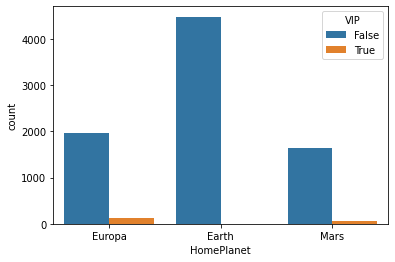

In [408]:
sns.countplot(data = df, x = 'HomePlanet', hue = 'VIP')

In [409]:
df['VIP'] = df['VIP'].fillna(False)

In [410]:
df['VIP'] = df['VIP'].apply(booltonum)

In [411]:
test['VIP'] = test['VIP'].fillna(False)

In [412]:
test['VIP'] = test['VIP'].apply(booltonum)

## CryoSleep

In [413]:
 df['CryoSleep'] = df['CryoSleep'].apply(booltonum)

In [414]:
df['CryoSleep'].isna().sum()

217

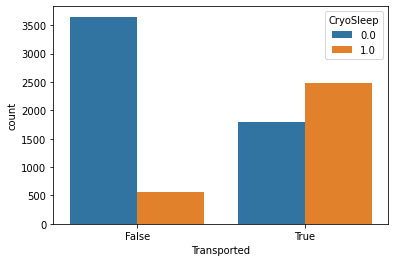

In [415]:
sns.countplot(data = df, x = 'Transported', hue = 'CryoSleep')

In [416]:
t1 = df[(df['CryoSleep'].isna() == True) & (df['Transported'] == False)] \
    .assign(cryo = np.random.choice([True,False], 
                                    len(df[(df['CryoSleep'].isna() == True) & (df['Transported'] == False)]),
                                    p=[0.15, 0.85]))
t2 = df[(df['CryoSleep'].isna() == True) & (df['Transported'] == True)] \
    .assign(cryo = np.random.choice([True,False], 
                                    len(df[(df['CryoSleep'].isna() == True) & (df['Transported'] == True)]),
                                    p=[0.55, 0.45]))
other = df[df['CryoSleep'].isna() == False] \
    .assign(cryo = df['CryoSleep'])
df = pd.concat([t1, t2, other], ignore_index=False, sort=False)
len(df)

8693

In [417]:
df = df.drop('CryoSleep',axis = 1).copy()
df.head()

,PassengerId,HomePlanet,Destination,Age,VIP,Transported,cryo
98,0105_01,Earth,TRAPPIST-1e,27.0,0,False,True
104,0110_02,Europa,TRAPPIST-1e,40.0,0,False,True
224,0241_01,Europa,55 Cancri e,33.0,0,False,False
453,0487_01,Europa,TRAPPIST-1e,39.0,0,False,False
533,0568_01,Europa,TRAPPIST-1e,33.0,0,False,False


In [418]:
df['cryo'] = df['cryo'].fillna(False)
df['cryo'] = df['cryo'].apply(booltonum)


In [419]:
test['CryoSleep'] = test['CryoSleep'].apply(booltonum)
test['CryoSleep'] = test['CryoSleep'].fillna(0)
test = test.rename(columns = {"CryoSleep":"cryo"})

## Age

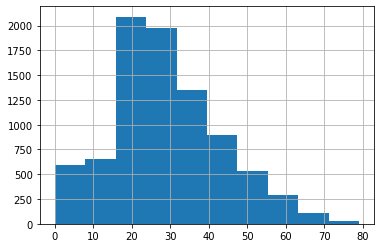

In [420]:
df['Age'].hist()

In [421]:
df['Age'] = df['Age'].fillna(df['Age'].mean())

In [422]:
test['Age'] = test['Age'].fillna(test['Age'].mean())

## Homeplanet

In [423]:
df['HomePlanet'].isna().sum()

201

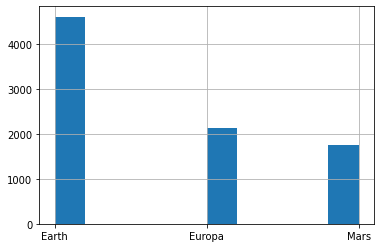

In [424]:
df['HomePlanet'].hist()

In [425]:
df['HomePlanet'] = df['HomePlanet'].fillna('Earth')

In [426]:
test['HomePlanet'] = test['HomePlanet'].fillna('Earth')

## Destination

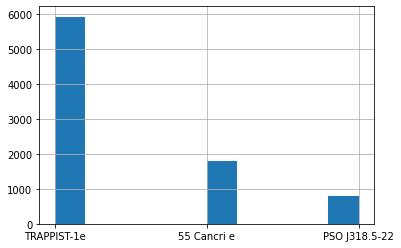

In [427]:
df['Destination'].hist()

In [428]:
df['Destination'] = df['Destination'].fillna('TRAPPIST-1e')

In [429]:
test['Destination'] = test['Destination'].fillna('TRAPPIST-1e')

## Model

In [430]:
df['Transported'] = df['Transported'].apply(booltonum) 

In [431]:
df.head()

,PassengerId,HomePlanet,Destination,Age,VIP,Transported,cryo
98,0105_01,Earth,TRAPPIST-1e,27.0,0,0,1
104,0110_02,Europa,TRAPPIST-1e,40.0,0,0,1
224,0241_01,Europa,55 Cancri e,33.0,0,0,0
453,0487_01,Europa,TRAPPIST-1e,39.0,0,0,0
533,0568_01,Europa,TRAPPIST-1e,33.0,0,0,0


In [432]:
len(df)

8693

In [433]:
df.columns

Index(['PassengerId', 'HomePlanet', 'Destination', 'Age', 'VIP', 'Transported',
       'cryo'],
      dtype='object')

In [434]:
df.dtypes

PassengerId     object
HomePlanet      object
Destination     object
Age            float64
VIP              int64
Transported      int64
cryo             int64
dtype: object

In [482]:
X = ['HomePlanet', 'Destination', 'Age', 'VIP', 'cryo']
cat_features = ['HomePlanet', 'Destination']
y = ['Transported']

In [496]:
model = CatBoostRegressor(cat_features = cat_features,
                          eval_metric = 'MAPE', 
                          random_seed = 42,
                          verbose=100,
                          learning_rate = 0.02)

In [497]:
train, val = train_test_split(df,train_size = 0.7, random_state = 1)

In [498]:
model.fit(train[X], train[y],eval_set=(val[X], val[y]))

0:	learn: 0.4971793	test: 0.4972920	best: 0.4972920 (0)	total: 3.65ms	remaining: 3.65s
100:	learn: 0.3758358	test: 0.3810674	best: 0.3810674 (100)	total: 205ms	remaining: 1.82s
200:	learn: 0.3583501	test: 0.3656739	best: 0.3656739 (200)	total: 408ms	remaining: 1.62s
300:	learn: 0.3540798	test: 0.3623009	best: 0.3623009 (300)	total: 595ms	remaining: 1.38s
400:	learn: 0.3520020	test: 0.3609650	best: 0.3609650 (400)	total: 801ms	remaining: 1.2s
500:	learn: 0.3506439	test: 0.3601800	best: 0.3601800 (500)	total: 1.01s	remaining: 1s
600:	learn: 0.3494350	test: 0.3597877	best: 0.3597877 (600)	total: 1.24s	remaining: 821ms
700:	learn: 0.3482532	test: 0.3594663	best: 0.3594522 (691)	total: 1.47s	remaining: 626ms
800:	learn: 0.3470589	test: 0.3590578	best: 0.3590521 (799)	total: 1.71s	remaining: 425ms
900:	learn: 0.3462347	test: 0.3588905	best: 0.3588723 (890)	total: 1.95s	remaining: 215ms
999:	learn: 0.3454060	test: 0.3588138	best: 0.3587863 (964)	total: 2.18s	remaining: 0us

bestTest = 0.35878

In [474]:
test['transported'] = model.predict(test[X])

In [478]:
test.head()

,PassengerId,HomePlanet,cryo,Destination,Age,VIP,transported,Transported
0,0013_01,Earth,1.0,TRAPPIST-1e,27.0,0,1,1
1,0018_01,Earth,0.0,TRAPPIST-1e,19.0,0,0,0
2,0019_01,Europa,1.0,55 Cancri e,31.0,0,1,1
3,0021_01,Europa,0.0,TRAPPIST-1e,38.0,0,0,0
4,0023_01,Earth,0.0,TRAPPIST-1e,20.0,0,0,0


In [477]:
test['Transported'] = test['transported'].round()

In [479]:
def inttobool(x):
    if x ==1:
        return True
    return False

In [480]:
test['Transported'] = test['Transported'].apply(inttobool)

In [481]:
test[['PassengerId', 'Transported']].to_csv('pred5.csv', index=False)